In [1]:
# Warning
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import numpy as np
import pandas as pd

# Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)

# Extração de dados

In [3]:
df = pd.read_csv('mlr_housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# Transformação de dados

In [4]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

df[varlist] = df[varlist].apply(binary_map)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [5]:
status = pd.get_dummies(df['furnishingstatus'])
status.head()

,furnished,semi-furnished,unfurnished
0,True,False,False
1,True,False,False
2,False,True,False
3,True,False,False
4,True,False,False


In [6]:
status = pd.get_dummies(df['furnishingstatus'])

In [7]:
df.drop(['furnishingstatus'], axis = 1, inplace = True)

In [8]:
df = pd.concat([df, status], axis = 1)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,True,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,True,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,False,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,True,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,True,False,False


# Visualização dos dados

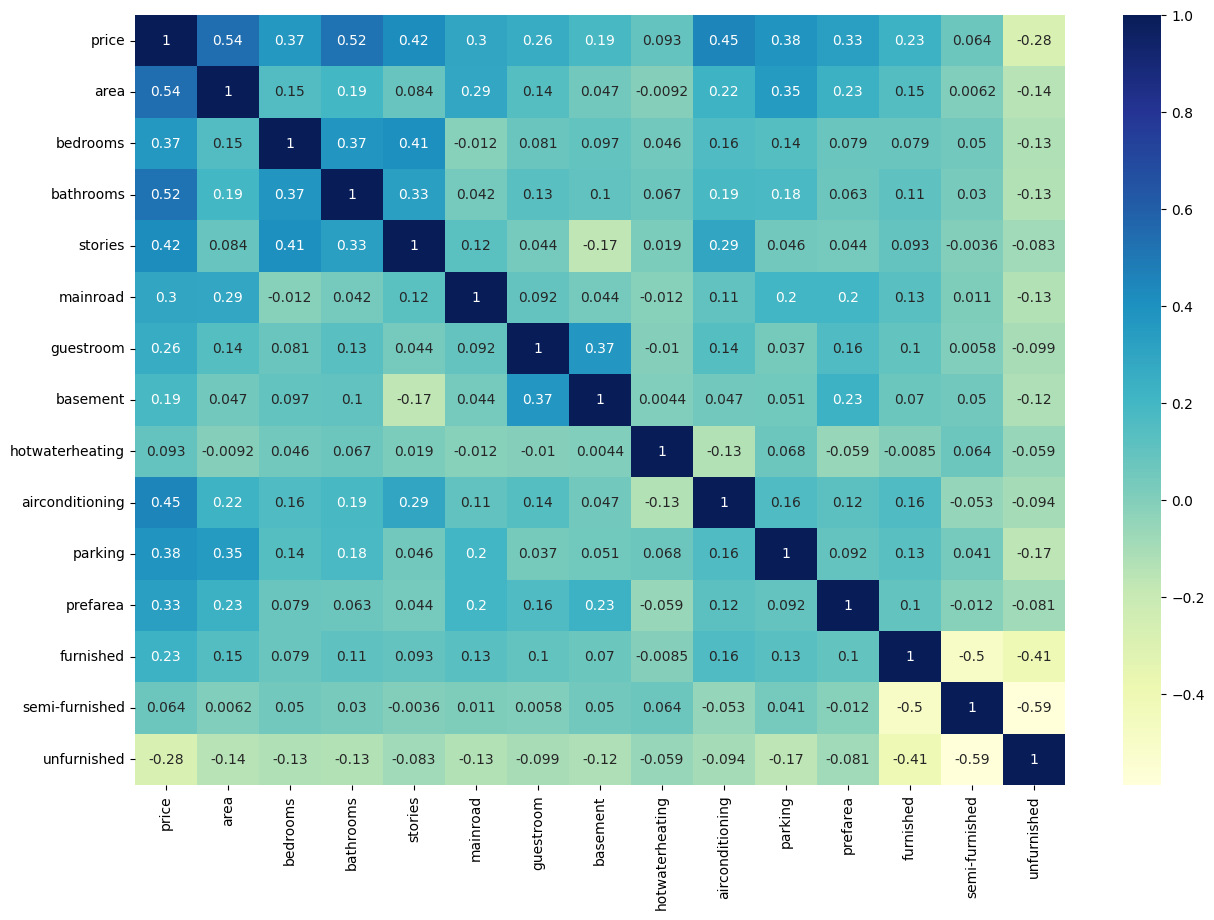

In [9]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

# 2. Construir um modelo de RLM

#### Criação de amostras

In [10]:
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [11]:
print(df_train.shape)
print(df_test.shape)

(436, 15)
(109, 15)


#### 2.1 Variáveis target e input

In [12]:
# target
y_train = df_train.pop('price')
# input
X_train = df_train

#### 2.2 Ajustando o modelo com OLS

In [13]:
X_train_lm = sm.add_constant(X_train.astype(float))
result = sm.OLS(y_train, X_train_lm).fit()

print(result.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     68.41
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           3.51e-95
Time:                        23:26:49   Log-Likelihood:                -6666.8
No. Observations:                 436   AIC:                         1.336e+04
Df Residuals:                     422   BIC:                         1.342e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         


In [14]:
print(result.pvalues[1:])

area              0.000
bedrooms          0.275
bathrooms         0.000
stories           0.000
mainroad          0.000
guestroom         0.011
basement          0.026
hotwaterheating   0.000
airconditioning   0.000
parking           0.000
prefarea          0.000
furnished         0.273
semi-furnished    0.807
unfurnished       0.001
dtype: float64


# 3. Fazer análise de suposições do modelo

#### 3.1 Relação linear entre variáveis

In [15]:
correlation = df_train.corrwith(y_train)
correlation = correlation[correlation.index != 'const']
correlation = correlation.sort_values(ascending=False)
correlation

bathrooms          0.538
area               0.530
airconditioning    0.437
stories            0.409
bedrooms           0.349
parking            0.347
mainroad           0.302
prefarea           0.297
guestroom          0.266
furnished          0.234
basement           0.177
hotwaterheating    0.117
semi-furnished     0.032
unfurnished       -0.252
dtype: float64

A correlação de pearson mostra que existe uma relação linear entre as variáveis, no entanto, a relação não é muito forte, algumas são muito fracas.

#### 3.2 Erros independentes

In [16]:
print(durbin_watson(result.resid))

2.0902754467623934


Um valor do teste de Durbin-Watson próximo de 2 sugere que os resíduos são independentes.

#### 3.3 Homoscedasticidade

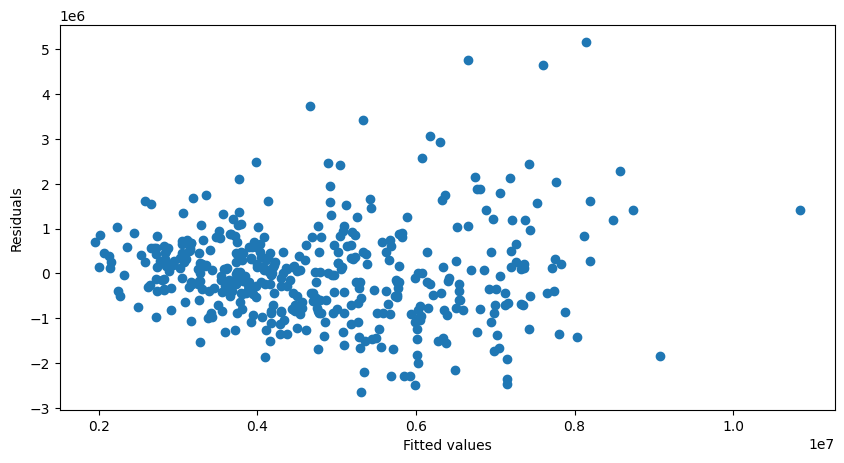

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Os resíduos possuem um comportamento aleatório com dispersão em torno de zero, comprovando que esses são não correlacionados.  

#### 3.4 Normalidade dos erros

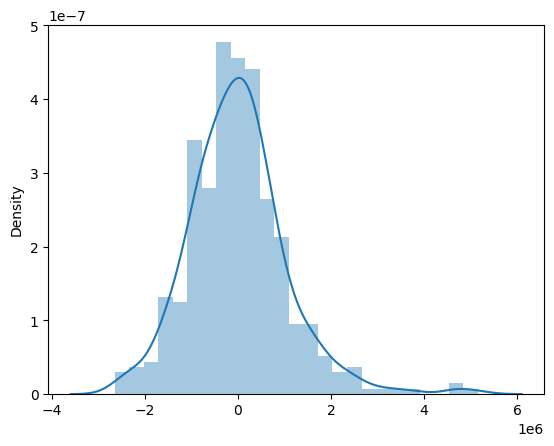

In [18]:
sns.distplot(result.resid)
plt.show()

Os erros seguem uma distribuição normal, levemente assimétrico para a direita.

#### 3.5 VIF

In [19]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.astype(float).values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,semi-furnished,12.110
13,unfurnished,8.950
11,furnished,8.590
3,stories,1.490
1,bedrooms,1.380
0,area,1.330
6,basement,1.320
2,bathrooms,1.310
5,guestroom,1.220
8,airconditioning,1.210


O VIF mostra que existem 1 variável com valor maior que 10, o que indica multicolinearidade. Também existem outras 2 com valores próximos de 10.

# Melhorando o modelo

In [20]:
# Retirar variáveis rejeitadas pelo VIF e P-Value
X_train = X_train.drop(['semi-furnished'], axis = 1)
X_train = X_train.drop(['unfurnished'], axis = 1)
X_train = X_train.drop(['furnished'], axis = 1)

# Retirar variáveis rejeitadas pelo P-Value
X_train = X_train.drop(['bedrooms'], axis = 1)

X_train_lm = sm.add_constant(X_train.astype(float))
result = sm.OLS(y_train, X_train_lm).fit()

print(result.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     85.80
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           1.95e-95
Time:                        23:26:49   Log-Likelihood:                -6673.1
No. Observations:                 436   AIC:                         1.337e+04
Df Residuals:                     425   BIC:                         1.341e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         


<p>Retirando as variáveis com VIF maior que 8, e com p-valor maior que 0.05 o modelo fica sem problemas de correlação entre as variáveis e significância, dessa forma ele se torna mais confiável.</P>

# 4. Avaliação do modelo

#### 4.1 Coeficientes das variáveis independentes

In [21]:
print(result.params[1:])

area                  249.954
bathrooms         1185284.666
stories            448428.551
mainroad           592389.362
guestroom          383007.651
basement           327288.567
hotwaterheating    904415.025
airconditioning    867014.425
parking            265841.236
prefarea           603309.865
dtype: float64


O coeficiente mais alto é o número de banheiros, o que sugere que essa característica tem o impacto mais significativo no valor da casa. O número de andares, a presença de aquecimento de água e ar condicionado também têm grandes impactos, indicando que essas características são altamente valorizadas pelos compradores. Características como área, porão, estacionamento e localização em uma rua principal têm impactos mais moderados, mas ainda contribuem para o aumento do valor da propriedade.

#### 4.2 Valores P

In [22]:
print(result.pvalues[1:])

area              0.000
bathrooms         0.000
stories           0.000
mainroad          0.000
guestroom         0.012
basement          0.008
hotwaterheating   0.000
airconditioning   0.000
parking           0.000
prefarea          0.000
dtype: float64


A área, o número de banheiros, o número de andares, a localização em rua principal, a presença de quarto de hóspedes, porão, aquecimento de água, ar condicionado, estacionamento, e a localização em área preferencial influenciam significativamente o valor da casa. No entanto, variáveis como o quarto de hóspedes e o porão têm p-valores um pouco mais altos (embora ainda menores que 0.05), o que indica que o impacto dessas variáveis é significativo, mas não tão forte quanto as demais (como o número de banheiros ou o ar condicionado).

#### R² e o R² ajustado

In [23]:
#print r2 e r2 ajustado
print("R²: ", result.rsquared)
print("R² ajustado", result.rsquared_adj)

R²:  0.6687426629583115
R² ajustado 0.6609483726749776


O R² em 66,78% indica que o modelo explica bem a variabilidade dos dados. O R² ajustado em 66,47% é muito próximo do R², o que sugere que o modelo não está sofrendo de overfitting, e que não se beneficiaria de mais variáveis independentes.

#### Resíduos

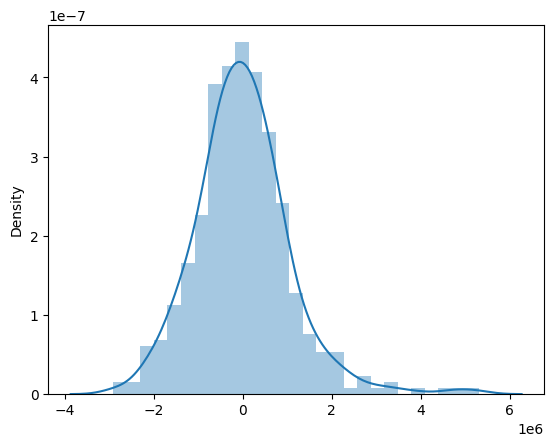

In [26]:
sns.distplot(result.resid)
plt.show()

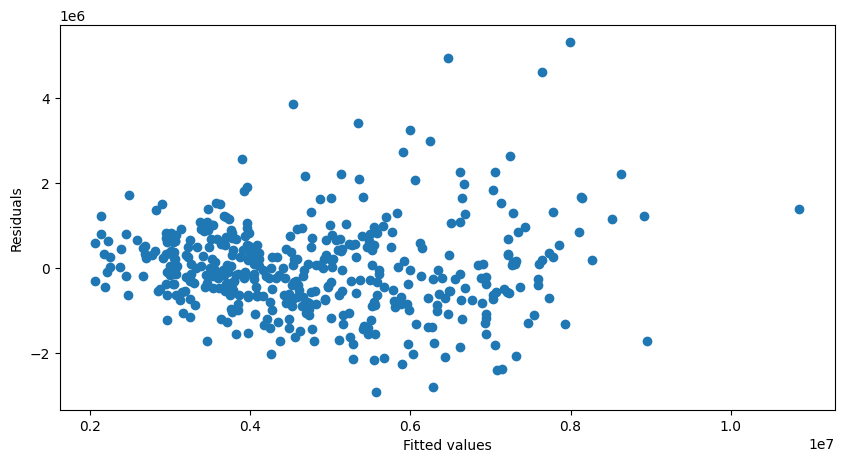

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

<p>Normalidade dos resíduos: A distribuição dos resíduos é quase normal, o que é um bom sinal. Pequenos desvios indicam a presença de alguns outliers, mas a normalidade geral parece estar bem atendida.</p>
<p>Homoscedasticidade: Não parece haver grandes problemas de heteroscedasticidade. A variância dos resíduos é aproximadamente constante em todo o intervalo de valores ajustados.</p>
<p>Outliers: Há alguns pontos mais distantes dos valores ajustados no gráfico de resíduos vs. valores ajustados. Esses outliers devem ser investigados, pois podem estar impactando o modelo.</p>

# 5. Validação do modelo

#### Teste do modelo

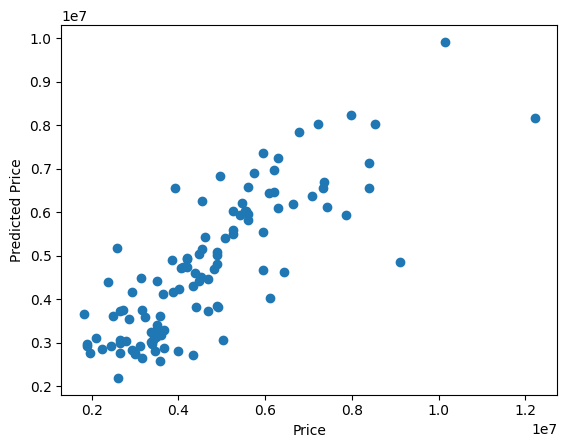

In [24]:
y_test = df_test.pop('price')
X_test = df_test[X_train.columns]

X_test_lm = sm.add_constant(X_test.astype(float))

y_pred = result.predict(X_test_lm)

plt.scatter(y_test, y_pred)
plt.xlabel('Price')

plt.ylabel('Predicted Price')

plt.show()

In [31]:
print('Preço máximo:', y_test.max())
print('Raiz do erro quadrático médio:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² score: ", r2_score(y_test, y_pred))

Preço máximo: 12215000
Raiz do erro quadrático médio: 1082792.3891209548
R² score:  0.6678153526489743


<p>Raiz do erro quadrático médio: Esse erro parece considerável, mas é importante lembrar que o preço máximo na base de teste é 12.215.000 unidades. Portanto, o erro médio (cerca de 1 milhão) é aproximadamente 8,5% do valor máximo de uma casa. Em termos relativos, isso não parece um erro grande</p>
<p>R² score: O valor do R² é muito próximo do R² que se obteve durante o ajuste do modelo na base de treino. Isso sugere que o modelo não está sofrendo de overfitting e está generalizando bem para a base de teste.</P>